In [2]:
import pandas as pd
import concurrent.futures
import requests
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import warnings
import statsmodels.api as sm

In [3]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sktime.clustering.k_means import TimeSeriesKMeans
from sklearn.metrics import silhouette_samples, silhouette_score, euclidean_distances
from sklearn.decomposition import PCA
from sktime.datatypes import convert_to
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from scipy.stats import pearsonr
from multiprocessing import Pool
from joblib import Parallel, delayed
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.spatial.distance import euclidean
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
#from sktime.forecasting.arima import ARIMA
from sktime.forecasting.model_selection import temporal_train_test_split
from pmdarima import auto_arima
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import MeanAbsoluteError
from sktime.forecasting.base import ForecastingHorizon

In [4]:
pair_list = [('JBHT', 'LOW'), ('DHI', 'LEN'), ('IQV', 'LH')]

In [5]:
fct_df  = pd.read_csv("yfinance_data.csv") 

In [6]:
fct_df.columns = fct_df.columns.str.lower()
fct_df  = fct_df[['date','open','close','ticker']]
fct_df['date'] = pd.to_datetime(fct_df['date'], utc=True)
fct_df['date'] = fct_df['date'].dt.tz_localize(None)


In [7]:
min_date = fct_df['date'].min()
max_date = fct_df['date'].max()

train_end = min_date + pd.DateOffset(years=4) 
test_end = max_date

train_df = fct_df[fct_df['date'] <= train_end] 
test_df = fct_df[(fct_df['date'] > train_end)]

print(f'Train period: {min(train_df["date"])} - {max(train_df["date"])}')
print(f'Test period: {min(test_df["date"])} - {max(test_df["date"])}')

Train period: 2018-12-04 05:00:00 - 2022-12-02 05:00:00
Test period: 2022-12-05 05:00:00 - 2023-12-04 05:00:00


In [8]:
def create_log_spread_series(data, pair):
    stock1_data = data[data['ticker'] == pair[0]]
    stock2_data = data[data['ticker'] == pair[1]]
    
    log_spread = np.log(stock1_data['close'].values) - np.log(stock2_data['close'].values)
    log_spread_df = pd.DataFrame({'date': stock1_data['date'], 'log_spread': log_spread})
    
    return log_spread_df

In [9]:
current_pair = pair_list[0]
pair_data = create_log_spread_series(train_df, current_pair)
print(pair_data.head())

                      date  log_spread
327903 2018-12-04 05:00:00    0.139659
327904 2018-12-06 05:00:00    0.160264
327905 2018-12-07 05:00:00    0.142127
327906 2018-12-10 05:00:00    0.142492
327907 2018-12-11 05:00:00    0.129343


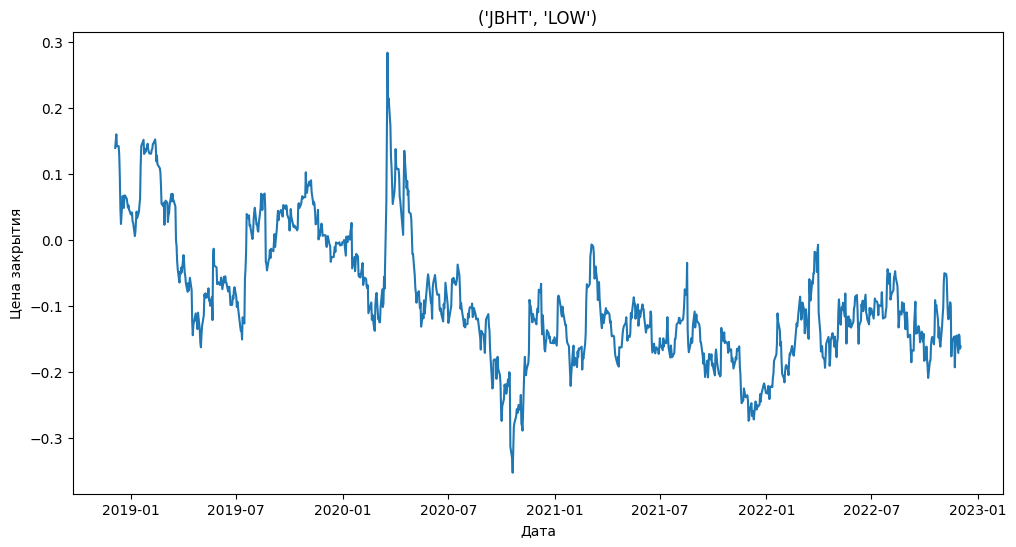

In [10]:
# Преобразование временного ряда
pair_data.set_index('date', inplace=True)
ts = pair_data['log_spread']

# Визуализация временного ряда
plt.figure(figsize=(12, 6))
plt.plot(ts)
plt.title(current_pair)
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.show()

In [11]:
# Проверка стационарности ряда
def test_stationarity(timeseries):
    # Критерий Дики-Фуллера
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

test_stationarity(ts)

Test Statistic                   -4.132577
p-value                           0.000855
#Lags Used                        1.000000
Number of Observations Used    1005.000000
Critical Value (1%)              -3.436873
Critical Value (5%)              -2.864420
Critical Value (10%)             -2.568304
dtype: float64


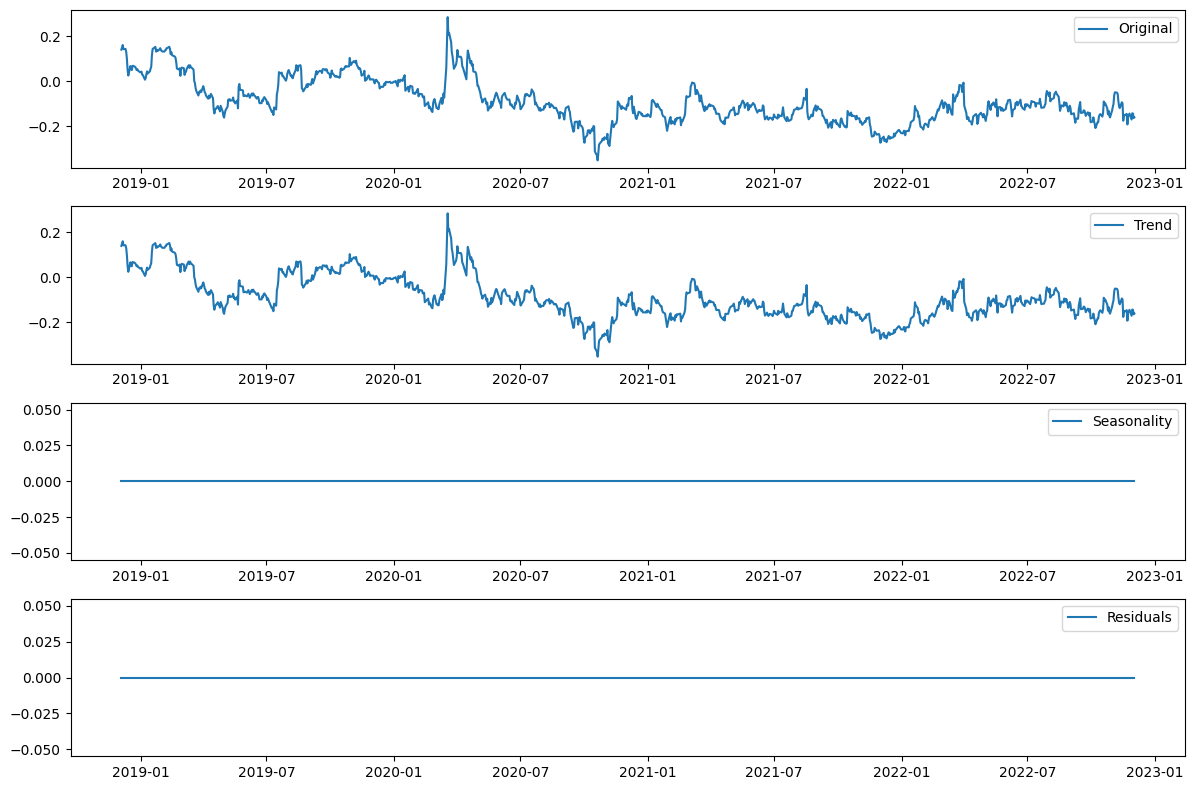

In [99]:
# Разложение временного ряда
decomposition = sm.tsa.seasonal_decompose(ts, model='additive', period=1)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Визуализация разложенных компонентов
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

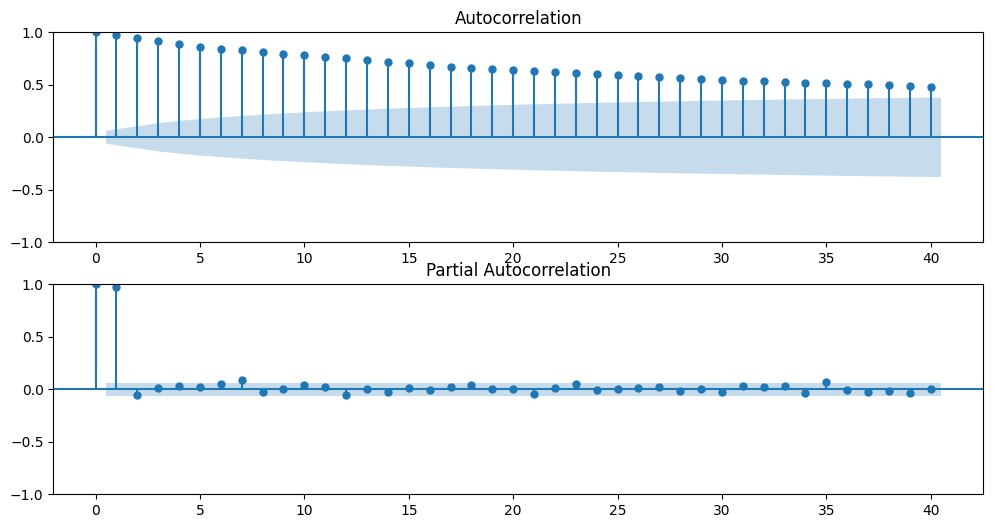

In [100]:
# Подбор параметров ARIMA
# Автокорреляционная и частичная автокорреляционная функции
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(211)
plot_acf(ts, lags=40, ax=ax1)
ax2 = plt.subplot(212)
plot_pacf(ts, lags=40, ax=ax2)
plt.show()

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1230.422, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-2415.236, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-3171.825, Time=0.09 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-3679.708, Time=0.83 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=-3930.623, Time=0.51 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=-4192.429, Time=0.77 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-4890.416, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-4890.514, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-4888.489, Time=0.14 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-4889.157, Time=0.15 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-4887.867, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-4890.501, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-4888.467, Time=0.15 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-4890.000, Time=0.34 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-4884.567, Time=0.70

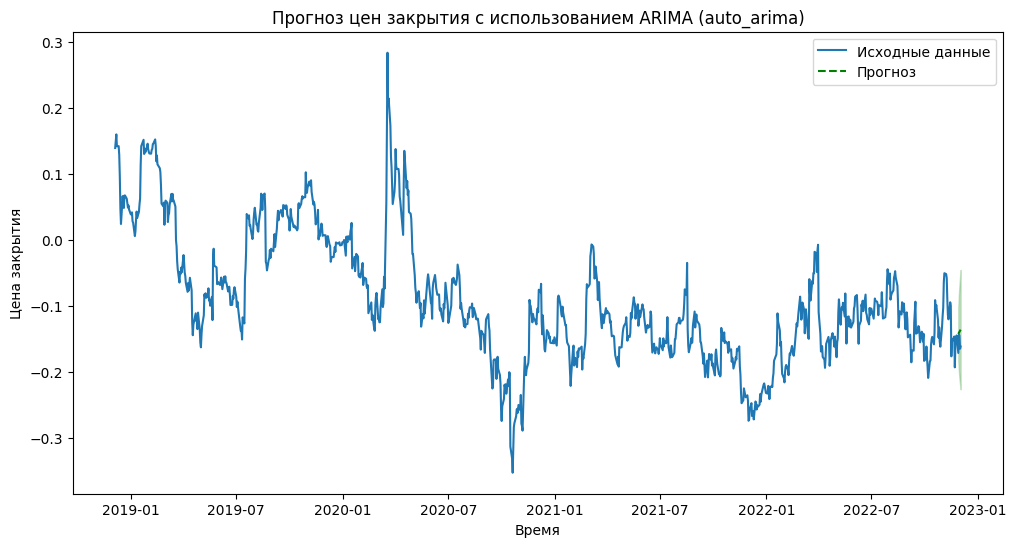

In [207]:
# Разделение временного ряда на обучающую и тестовую выборки
train_size = int(1002)
train, test = ts[:train_size], ts[train_size:]

# Подбор модели ARIMA на обучающей выборке
auto_model = auto_arima(train, start_p=1, start_q=1,
                        test='adf',       # использование ADF теста для определения 'd'
                        max_p=5, max_q=5, # максимальные значения p и q для проверки
                        m=1,              # периодичность данных для сезонности (если есть)
                        d=None,           # позволить auto_arima определить 'd'
                        seasonal=False,   # без учета сезонности
                        start_P=0, D=0,
                        trace=True,       # вывод информации о процессе подбора
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=False)    # использование пошагового алгоритма для оптимизации

# Обучение модели ARIMA на обучающей выборке с лучшими параметрами
best_p, best_d, best_q = auto_model.order
model = ARIMA(train, order=(best_p, best_d, best_q))
model_fit = model.fit()

# Прогнозирование
forecast_steps = len(test)  # количество шагов для прогноза равно размеру тестовой выборки
forecast_results = model_fit.get_forecast(steps=forecast_steps)
forecast = forecast_results.predicted_mean
conf_int = forecast_results.conf_int()

# Индекс для прогнозных значений
forecast_index = test.index

# Шаг 5: Визуализация прогноза
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Исходные данные')
plt.plot(forecast_index, forecast, color='green', label='Прогноз', linestyle='--')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.2)
plt.title('Прогноз цен закрытия с использованием ARIMA (auto_arima)')
plt.xlabel('Время')
plt.ylabel('Цена закрытия')
plt.legend(loc='best')
plt.show()

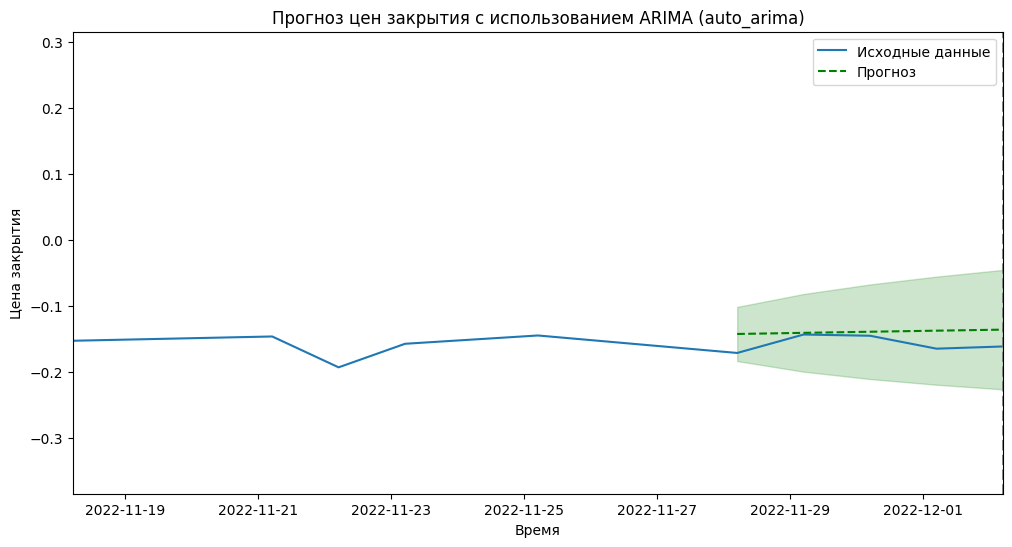

In [208]:
# Шаг 5: Визуализация прогноза
plt.figure(figsize=(12, 6))
# Сначала рисуем весь временной ряд
plt.plot(ts, label='Исходные данные')
# Затем рисуем прогноз
plt.plot(forecast_index, forecast, color='green', label='Прогноз', linestyle='--')
# Добавляем доверительные интервалы
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.2)
# Вертикальная линия, обозначающая начало прогноза
plt.axvline(x=ts.index[-1], color='grey', linestyle='--', linewidth=2)
# Ограничиваем отображаемый интервал для крупного рассмотрения
plt.xlim([ts.index[-10], forecast_index[-1]])
plt.title('Прогноз цен закрытия с использованием ARIMA (auto_arima)')
plt.xlabel('Время')
plt.ylabel('Цена закрытия')
plt.legend(loc='best')
plt.show()

In [210]:
def directional_accuracy(true_values, predictions):
    # Определение направления изменения для истинных значений и предсказаний
    true_directions = np.sign(np.diff(true_values))
    predicted_directions = np.sign(np.diff(predictions))
    # Сравнение направлений и подсчет точности
    accuracy = np.sum(true_directions == predicted_directions) / len(true_directions)
    return accuracy

# Инициализация списков для сохранения метрик
mae_scores = []
directional_accuracies = []

n_folds = 20
forecast_steps = 5

for i in range(n_folds):
    # Определение обучающего и тестового наборов
    train_end = len(ts) - (n_folds - i) * forecast_steps
    train, test = ts[:train_end], ts[train_end:train_end + forecast_steps]
    
    # Подбор модели ARIMA
    auto_model = auto_arima(train, start_p=1, start_q=1, test='adf', max_p=5, max_q=5, m=1,
                            d=None, seasonal=False, start_P=0, D=0, trace=False,
                            error_action='ignore', suppress_warnings=True, stepwise=True)
    
    # Обучение модели ARIMA
    best_p, best_d, best_q = auto_model.order
    model = ARIMA(train, order=(best_p, best_d, best_q))
    model_fit = model.fit()
    
    # Прогнозирование
    forecast = model_fit.get_forecast(steps=forecast_steps).predicted_mean
    
    # Расчет MAE
    mae = mean_absolute_error(test, forecast)
    mae_scores.append(mae)
    
    # Расчет точности угадывания направления
    dir_acc = directional_accuracy(test.values, forecast.values)
    directional_accuracies.append(dir_acc)

# Вывод средних метрик
print(f'Средний MAE: {np.mean(mae_scores)}')
print(f'Средняя точность угадывания направления: {np.mean(directional_accuracies)}')

Средний MAE: 0.02676979511541087
Средняя точность угадывания направления: 0.65


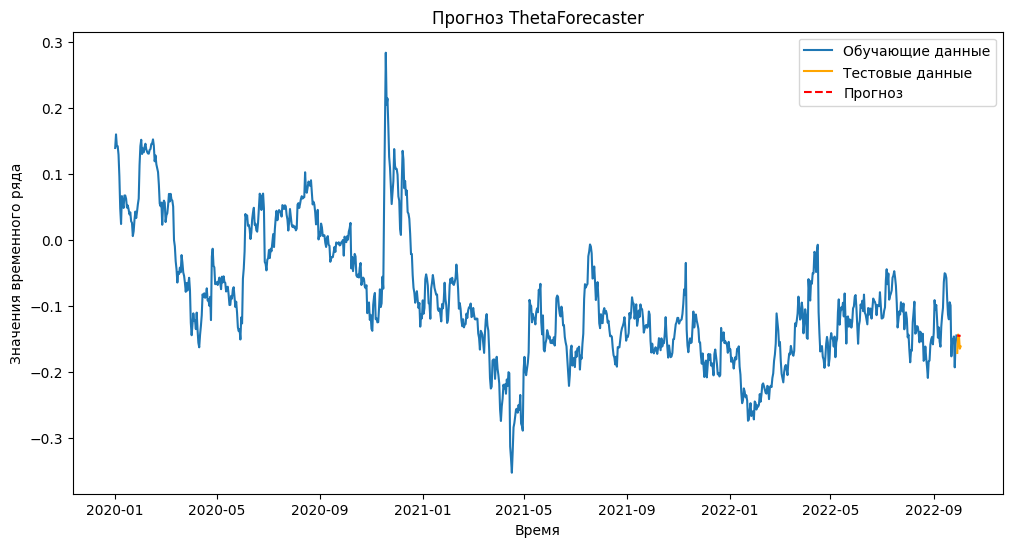

In [216]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import MeanAbsoluteError
import matplotlib.pyplot as plt
import pandas as pd

# Предполагаем, что ts - это ваш временной ряд
# Установите правильную частоту для вашего временного ряда
ts = pd.Series(ts.values, index=pd.date_range(start='2020-01-01', periods=len(ts), freq='D'))

# Разделение временного ряда на обучающую и тестовую выборки
y_train, y_test = temporal_train_test_split(ts, test_size=5)

# Инициализация ThetaForecaster без десезонирования
forecaster = ThetaForecaster(sp=1, deseasonalize=False)
forecaster.fit(y_train)

# Прогнозирование
fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh)

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(y_train, label='Обучающие данные')
plt.plot(y_test, label='Тестовые данные', color='orange')
plt.plot(y_pred, label='Прогноз', color='red', linestyle='--')
plt.title('Прогноз ThetaForecaster')
plt.xlabel('Время')
plt.ylabel('Значения временного ряда')
plt.legend()
plt.show()


Средний MAE: 0.02711989001402613
Средняя точность угадывания направления: 0.50625


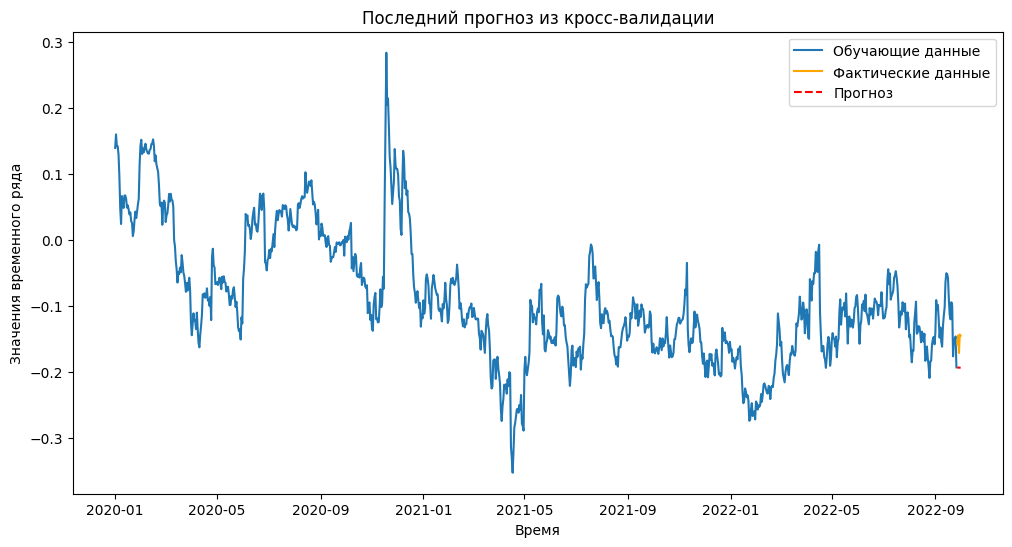

In [221]:
import matplotlib.pyplot as plt
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.theta import ThetaForecaster
from sklearn.metrics import mean_absolute_error
import numpy as np

# Функция для расчета точности направления
def directional_accuracy(true_values, predictions):
    true_directions = np.sign(np.diff(true_values))
    predicted_directions = np.sign(np.diff(predictions))
    accuracy = np.sum(true_directions == predicted_directions) / len(true_directions)
    return accuracy

# Инициализация списков для сохранения метрик
mae_scores = []
directional_accuracies = []

n_folds = 20
forecast_steps = 5

# Инициализация кросс-валидации с увеличивающимся окном
cv = ExpandingWindowSplitter(initial_window=int(len(ts) * 0.8), step_length=forecast_steps, fh=[1,2,3,4,5])

# Процесс кросс-валидации
for train_idx, test_idx in cv.split(ts):
    # Разделение на обучающую и тестовую выборку
    y_train, y_test = ts.iloc[train_idx], ts.iloc[test_idx]
    fh = ForecastingHorizon(y_test.index, is_relative=False)
    
    # Обучение модели Theta
    forecaster = ThetaForecaster(sp=1, deseasonalize=False)
    forecaster.fit(y_train)
    
    # Прогнозирование
    y_pred = forecaster.predict(fh)
    
    # Вычисление метрик
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    directional_accuracies.append(directional_accuracy(y_test, y_pred))

# Вывод средних метрик
print(f'Средний MAE: {np.mean(mae_scores)}')
print(f'Средняя точность угадывания направления: {np.mean(directional_accuracies)}')

# Визуализация последнего прогноза из кросс-валидации
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Обучающие данные')
plt.plot(y_test.index, y_test, label='Фактические данные', color='orange')
plt.plot(y_pred.index, y_pred, label='Прогноз', color='red', linestyle='--')
plt.title('Последний прогноз из кросс-валидации')
plt.xlabel('Время')
plt.ylabel('Значения временного ряда')
plt.legend()
plt.show()

Средний MAE: 0.027079459636858365
Средняя точность угадывания направления: 0.0


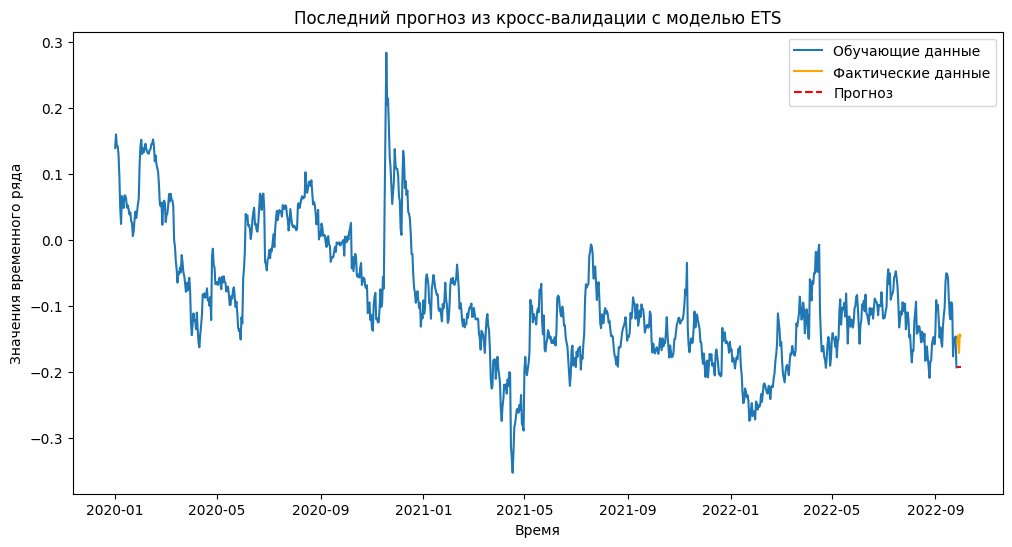

In [222]:
import matplotlib.pyplot as plt
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.ets import AutoETS
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd

# Функция для расчета точности направления
def directional_accuracy(true_values, predictions):
    true_directions = np.sign(np.diff(true_values))
    predicted_directions = np.sign(np.diff(predictions))
    accuracy = np.sum(true_directions == predicted_directions) / len(true_directions)
    return accuracy

# Инициализация списков для сохранения метрик
mae_scores = []
directional_accuracies = []

n_folds = 20
forecast_steps = 5

# Инициализация кросс-валидации с увеличивающимся окном
cv = ExpandingWindowSplitter(initial_window=int(len(ts) * 0.8), step_length=forecast_steps, fh=[1,2,3,4,5])

# Процесс кросс-валидации
for train_idx, test_idx in cv.split(ts):
    # Разделение на обучающую и тестовую выборку
    y_train, y_test = ts.iloc[train_idx], ts.iloc[test_idx]
    fh = ForecastingHorizon(y_test.index, is_relative=False)
    
    # Обучение модели ETS
    forecaster = AutoETS(auto=True, sp=1, n_jobs=-1)
    forecaster.fit(y_train)
    
    # Прогнозирование
    y_pred = forecaster.predict(fh)
    
    # Вычисление метрик
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    directional_accuracies.append(directional_accuracy(y_test, y_pred))

# Вывод средних метрик
print(f'Средний MAE: {np.mean(mae_scores)}')
print(f'Средняя точность угадывания направления: {np.mean(directional_accuracies)}')

# Визуализация последнего прогноза из кросс-валидации
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Обучающие данные')
plt.plot(y_test.index, y_test, label='Фактические данные', color='orange')
plt.plot(y_pred.index, y_pred, label='Прогноз', color='red', linestyle='--')
plt.title('Последний прогноз из кросс-валидации с моделью ETS')
plt.xlabel('Время')
plt.ylabel('Значения временного ряда')
plt.legend()
plt.show()


In [11]:
input_dim = 5
hidden_dim = 10
n_layers = 1

lstm_layer = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)

In [12]:
batch_size = 1
seq_len = 1

inp = torch.randn(batch_size, seq_len, input_dim)
hidden_state = torch.randn(n_layers, batch_size, hidden_dim)
cell_state = torch.randn(n_layers, batch_size, hidden_dim)
hidden = (hidden_state, cell_state)

In [13]:
out, hidden = lstm_layer(inp, hidden)
print("Output shape: ", out.shape)
print("Hidden: ", hidden)

Output shape:  torch.Size([1, 1, 10])
Hidden:  (tensor([[[-0.0933, -0.0416,  0.1637, -0.2164,  0.0254,  0.0006,  0.2647,
          -0.0560, -0.1520, -0.1238]]], grad_fn=<StackBackward0>), tensor([[[-0.1483, -0.0510,  0.4775, -0.3989,  0.0355,  0.0015,  0.5995,
          -0.1006, -0.4304, -0.2044]]], grad_fn=<StackBackward0>))


In [14]:
seq_len = 3
inp = torch.randn(batch_size, seq_len, input_dim)
out, hidden = lstm_layer(inp, hidden)
print(out.shape)

torch.Size([1, 3, 10])


In [15]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

# Определение модели LSTM
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

# Предполагаем, что 'ts' - это ваш временной ряд
# Нормализация временного ряда
scaler = MinMaxScaler(feature_range=(-1, 1))
ts_normalized = scaler.fit_transform(ts.values.reshape(-1, 1))
ts_normalized = torch.FloatTensor(ts_normalized).view(-1)

# Создание последовательностей данных
train_window = 12
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(ts_normalized, train_window)

# Обучение модели
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 100

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')


epoch:   1 loss: 0.00174119
epoch:  26 loss: 0.00018466
epoch:  51 loss: 0.00041683
epoch:  76 loss: 0.00024757
epoch: 101 loss: 0.00020853
epoch: 126 loss: 0.00019229
epoch: 149 loss: 0.0002538873


In [18]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

# Определение модели LSTM
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

# Функция для создания последовательностей данных
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

# Функция для расчета точности направления
def directional_accuracy(true_values, predictions):
    true_directions = np.sign(np.diff(true_values))
    predicted_directions = np.sign(np.diff(predictions))
    accuracy = np.sum(true_directions == predicted_directions) / len(true_directions)
    return accuracy

# Предполагаем, что 'ts' - это ваш временной ряд
# Нормализация временного ряда
scaler = MinMaxScaler(feature_range=(-1, 1))
ts_normalized = scaler.fit_transform(ts.values.reshape(-1, 1))
ts_normalized = torch.FloatTensor(ts_normalized).view(-1)

# Создание последовательностей данных
train_window = 12
train_inout_seq = create_inout_sequences(ts_normalized, train_window)

# Обучение модели
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 100

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

# Разделение данных на обучение и тест
train_size = int(len(train_inout_seq) * 0.7)
train_seq = train_inout_seq[:train_size]
test_seq = train_inout_seq[train_size:]

# Тестирование модели и вычисление метрик
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for seq, labels in test_seq:
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))
        y_pred.append(model(seq).item())
        y_true.append(labels.item())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Вычисление MAE и точности направления
mae = mean_absolute_error(y_true, y_pred)
dir_acc = directional_accuracy(y_true, y_pred)

print(f'MAE: {mae}')
print(f'Directional Accuracy: {dir_acc}')


epoch:   1 loss: 0.00162753
epoch:  26 loss: 0.00019075
epoch:  51 loss: 0.00029589
epoch:  76 loss: 0.00022129
epoch:  99 loss: 0.0002571936
MAE: 0.05416942648215836
Directional Accuracy: 0.4798657718120805


In [23]:
from prophet import Prophet
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

# Предполагаем, что ts - это ваш временной ряд
ts = pd.Series(ts.values, index=pd.date_range(start='2020-01-01', periods=len(ts), freq='D'))

# Преобразование данных в формат, совместимый с fbprophet
df = pd.DataFrame({'ds': ts.index, 'y': ts.values})

# Функция для расчета точности направления
def directional_accuracy(true_values, predictions):
    true_directions = np.sign(np.diff(true_values))
    predicted_directions = np.sign(np.diff(predictions))
    accuracy = np.sum(true_directions == predicted_directions) / len(true_directions)
    return accuracy

# Количество фолдов для кросс-валидации
n_splits = 20
test_size = 5  # Размер тестового набора
total_size = len(df)

mae_scores = []
directional_accuracies = []

for i in range(n_splits):
    # Определение индексов для обучающего и тестового наборов
    train_size = int(total_size - (n_splits - i) * test_size)
    train_df = df.iloc[:train_size]
    test_df = df.iloc[train_size:train_size + test_size]

    # Инициализация и обучение модели
    model = Prophet()
    model.fit(train_df)

    # Создание датафрейма для прогнозирования
    future = model.make_future_dataframe(periods=test_size, freq='D')

    # Прогнозирование
    forecast = model.predict(future)

    # Вычисление MAE
    mae = mean_absolute_error(test_df['y'], forecast['yhat'].tail(test_size))
    mae_scores.append(mae)

    # Вычисление точности направления
    dir_acc = directional_accuracy(test_df['y'], forecast['yhat'].tail(test_size))
    directional_accuracies.append(dir_acc)

# Вывод средних метрик
average_mae = sum(mae_scores) / len(mae_scores)
average_directional_accuracy = sum(directional_accuracies) / len(directional_accuracies)
print(f'Средний MAE: {average_mae}')
print(f'Средняя точность угадывания направления: {average_directional_accuracy}')


21:52:46 - cmdstanpy - INFO - Chain [1] start processing
21:52:46 - cmdstanpy - INFO - Chain [1] done processing
21:52:47 - cmdstanpy - INFO - Chain [1] start processing
21:52:47 - cmdstanpy - INFO - Chain [1] done processing
21:52:48 - cmdstanpy - INFO - Chain [1] start processing
21:52:48 - cmdstanpy - INFO - Chain [1] done processing
21:52:49 - cmdstanpy - INFO - Chain [1] start processing
21:52:49 - cmdstanpy - INFO - Chain [1] done processing
21:52:49 - cmdstanpy - INFO - Chain [1] start processing
21:52:49 - cmdstanpy - INFO - Chain [1] done processing
21:52:50 - cmdstanpy - INFO - Chain [1] start processing
21:52:50 - cmdstanpy - INFO - Chain [1] done processing
21:52:50 - cmdstanpy - INFO - Chain [1] start processing
21:52:50 - cmdstanpy - INFO - Chain [1] done processing
21:52:51 - cmdstanpy - INFO - Chain [1] start processing
21:52:51 - cmdstanpy - INFO - Chain [1] done processing
21:52:51 - cmdstanpy - INFO - Chain [1] start processing
21:52:51 - cmdstanpy - INFO - Chain [1]

Средний MAE: 0.06683826393466667
Средняя точность угадывания направления: 0.5875
